# Práctica final | Deep Learning para NLP

In [1]:
# !pip uninstall -y transformers
# !pip install --upgrade transformers
# !pip uninstall -y datasets
!pip install --upgrade datasets
# !pip uninstall -y wandb
# !pip install --upgrade wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
import wandb
from datetime import datetime
from scipy.stats import pearsonr, spearmanr
from google.colab import drive


In [ ]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.51.3


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [5]:
base_path = "/content/drive/MyDrive/Master Deep Learning UPM/MLOPS/practica final/artefactos"

In [6]:
# Cargar el dataset desde Hugging Face
dataset = load_dataset("mteb/stsbenchmark-sts")
display(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.67k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['split', 'genre', 'dataset', 'year', 'sid', 'score', 'sentence1', 'sentence2'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['split', 'genre', 'dataset', 'year', 'sid', 'score', 'sentence1', 'sentence2'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['split', 'genre', 'dataset', 'year', 'sid', 'score', 'sentence1', 'sentence2'],
        num_rows: 1379
    })
})

## Exploración del dataset y tokenización

In [7]:
df_train = pd.DataFrame(dataset["train"])
df_validation = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

print("Ejemplo de datos de entrenamiento:")
df_train.head(5)

Ejemplo de datos de entrenamiento:


,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,0001,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,0004,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,0005,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,0006,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,0009,4.25,A man is playing the cello.,A man seated is playing the cello.


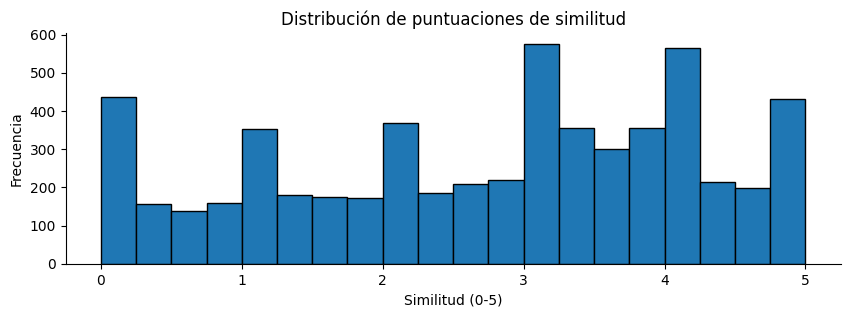

In [8]:
plt.figure(figsize=(10, 3))
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.hist(df_train["score"], bins=20, edgecolor="black")
plt.xlabel("Similitud (0-5)")
plt.ylabel("Frecuencia")
plt.title("Distribución de puntuaciones de similitud")
plt.show()

>Aunque las frecuencias no están equidistribuidas, asumimos que su distribución es suficientemente válida para el entrenemiento del modelo

In [9]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenizar un ejemplo de texto para ver su estructura
example_texts = [df_train["sentence1"][0], df_train["sentence2"][0]]
example_tokens = tokenizer(example_texts, padding=True, truncation=True, return_tensors="pt")

# Mostrar un ejemplo de tokenización
print("\nEjemplo de Tokenización:")
print(tokenizer.convert_ids_to_tokens(example_tokens["input_ids"][0]))
print(tokenizer.convert_ids_to_tokens(example_tokens["input_ids"][1]))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Ejemplo de Tokenización:
['[CLS]', 'a', 'plane', 'is', 'taking', 'off', '.', '[SEP]', '[PAD]']
['[CLS]', 'an', 'air', 'plane', 'is', 'taking', 'off', '.', '[SEP]']


>Tokenización del dataset

In [10]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], padding="max_length", truncation=True)

# Aplicar tokenización
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Eliminar columnas innecesarias
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2"])

# Renombrar "score" a "labels" (para compatibilidad con `Trainer`)
tokenized_datasets = tokenized_datasets.rename_column("score", "labels")

# Convertir a formato `torch`
tokenized_datasets.set_format("torch")

# Mostrar una muestra preprocesada
print("Ejemplo de datos tokenizados:")
print(tokenized_datasets["train"][0])


Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Ejemplo de datos tokenizados:
{'split': 'train', 'genre': 'main-captions', 'dataset': 'MSRvid', 'year': '2012test', 'sid': '0001', 'labels': tensor(5.), 'input_ids': tensor([ 101, 1037, 4946, 2003, 2635, 2125, 1012,  102, 2019, 2250, 4946, 2003,
        2635, 2125, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

Algunas funciones para este notebook

In [11]:
# Función para contar los parámetros entrenables del modelo
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Función para la evaluación


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Convierte a arrays de numpy y asegúrate que son 1D
    predictions = np.array(predictions).reshape(-1)
    labels = np.array(labels).reshape(-1)
    pearson = pearsonr(predictions, labels)[0]
    spearman = spearmanr(predictions, labels)[0]
    mse = np.mean((predictions - labels) ** 2)
    return {
        "eval_pearson": pearson,
        "eval_spearman": spearman,
        "eval_mse": mse
    }


# Función para predecir la similitud entre dos textos
def predict_similarity(text1, text2, model, tokenizer):
    model.eval()
    inputs = tokenizer(text1, text2, return_tensors="pt", padding=True, truncation=True)

    # Mover los tensores de entrada al dispositivo del modelo (GPU si está disponible)
    device = next(model.parameters()).device  # Obtener el dispositivo del modelo
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Mover los tensores

    with torch.no_grad():
        prediction = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
    return prediction.item()

# Función para visualizar en un df la evaluación del modelo
def test_similarity(test_pairs, model, tokenizer):
    resultados = []
    for text1, text2 in test_pairs:
        similitud = predict_similarity(text1, text2, model, tokenizer)
        resultados.append({
            "Texto 1": text1,
            "Texto 2": text2,
            "Similitud": similitud,
            "Similitud redondeada": round(similitud, 0)
        })

    df = pd.DataFrame(resultados)
    return df.head(6)

##Propuesta #3: Sustitución del token [CLS] por el embedding promedio de toda la secuencia

>Repetimos la configuración para el entrenamiento del RegressionModel_v2

In [12]:
class RegressionModel_v3(nn.Module):
    def __init__(self, model_name="bert-base-uncased", freeze_layers=2, freeze_embeddings=True):
        super(RegressionModel_v3, self).__init__()

        self.model = AutoModel.from_pretrained(model_name)

        #Congelar la capa de embeddigns
        if freeze_embeddings:
            for param in self.model.embeddings.parameters():
                param.requires_grad = False

        # Congelar las primeras 'freeze_layers' capas
        if freeze_layers > 0:
            for layer in self.model.encoder.layer[:freeze_layers]:
                for param in layer.parameters():
                    param.requires_grad = False

        # Capa de regresión: toma la salida del token [CLS] y predice la similitud
        self.regression_head = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 2048), # 768 -> 2048
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        self.loss_fn = nn.MSELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        mean_pooled = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)
        raw_output = self.regression_head(mean_pooled)
        predictions = raw_output * 5

        # Calcular pérdida si se proporcionan etiquetas
        loss = None
        if labels is not None:
            loss = self.loss_fn(predictions.view(-1), labels.view(-1))
            return loss, predictions  # Devolver ambos en entrenamiento

        return predictions  # Devolver solo predicciones en inferencia

In [13]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: p-cerezomarin (p-cerezomarin-universidad-polit-cnica-de-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
# Configura variantes y nombres
versiones = {
    "baseline":  {"freeze_layers": 6, "freeze_embeddings": True},      # Ejemplo: baseline, capas congeladas
    "freeze4":   {"freeze_layers": 4, "freeze_embeddings": True},      # Menos capas congeladas
    "all_unfrozen": {"freeze_layers": 0, "freeze_embeddings": False},  # Todo entrenable
}

# Sweep config para wandb
sweep_config = {
    'method': 'grid',
    'parameters': {
        'version_name': {'values': list(versiones.keys())},
    }
}

# Define la función de entrenamiento
def train():
    wandb.init()
    config = wandb.config

    # Extrae la config de cada versión
    params = versiones[config.version_name]
    freeze_layers = params['freeze_layers']
    freeze_embeddings = params['freeze_embeddings']

    # Instancia el modelo usando tu clase de modelo CLS
    model = RegressionModel_v3(
        freeze_layers=freeze_layers,
        freeze_embeddings=freeze_embeddings
    )

    # Optimizer
    optimizer = torch.optim.AdamW([
        {"params": model.model.parameters(), "lr": 2e-5},
        {"params": model.regression_head.parameters(), "lr": 2e-4}
    ], weight_decay=0.01)

    # TrainingArguments
    training_args = TrainingArguments(
        output_dir=f"{base_path}/outputs_{config.version_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.01,
        logging_dir=f"{base_path}/logs_{config.version_name}",
        logging_steps=50,
        report_to="wandb",
        run_name=f"{config.version_name}",
        load_best_model_at_end=True,
        metric_for_best_model="eval_pearson",
        greater_is_better=True,
    )

    # EarlyStopping callback si lo usas
    early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

    # Entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
        optimizers=(optimizer, None),
        callbacks=[early_stopping]
    )

    # Entrenamiento
    trainer.train()

    # Evaluación en test
    test_metrics = trainer.evaluate(tokenized_datasets["test"])
    print(f"Métricas de test ({config.version_name}):", test_metrics)
    wandb.log({
        "test/pearson": test_metrics.get("eval_pearson", 0),
        "test/loss": test_metrics.get("eval_loss", 0),
    })

    # Guarda el modelo y el tokenizer (PyTorch + HuggingFace)
    model_path = f"{base_path}/modelo_final_{config.version_name}.pt"
    torch.save(model.state_dict(), model_path)

    tokenizer_path = f"{base_path}/tokenizer_{config.version_name}"
    tokenizer.save_pretrained(tokenizer_path)

    # Subir como artefacto a wandb
    artifact = wandb.Artifact(f"modelo_final_{config.version_name}", type="model")
    artifact.add_file(model_path)
    artifact.add_dir(tokenizer_path)
    wandb.log_artifact(artifact)


# Inicia el sweep
sweep_id = wandb.sweep(sweep_config, project="similarity-text-prediction")  # Cambia el nombre por el de tu proyecto
wandb.agent(sweep_id, function=train)


Create sweep with ID: ua1lplen
Sweep URL: https://wandb.ai/p-cerezomarin-universidad-polit-cnica-de-madrid/similarity-text-prediction/sweeps/ua1lplen


wandb: Agent Starting Run: iopxv2zm with config:
wandb: 	version_name: baseline


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Pearson,Spearman,Mse
1,0.859500,0.752552,0.829512,0.832201,0.752552
2,0.675200,0.833349,0.829715,0.832600,0.833349
3,0.572700,0.666549,0.844904,0.842558,0.666549
4,0.454200,0.710330,0.841971,0.840236,0.710330


Métricas de test (baseline): {'eval_pearson': 0.795862078666687, 'eval_spearman': 0.7794975929734045, 'eval_mse': 0.8584192991256714, 'eval_loss': 0.8584192991256714, 'eval_runtime': 40.6795, 'eval_samples_per_second': 33.899, 'eval_steps_per_second': 1.082, 'epoch': 4.0}


wandb: Adding directory to artifact (/content/drive/MyDrive/Master Deep Learning UPM/MLOPS/practica final/artefactos/tokenizer_baseline)... Done. 0.1s


eval/loss,▄▇▁▃█
eval/mse,▄▇▁▃█
eval/pearson,▆▆██▁
eval/runtime,████▁
eval/samples_per_second,██▇█▁
eval/spearman,▇▇██▁
eval/steps_per_second,▂▁▁▁█
test/loss,▁
test/pearson,▁
train/epoch,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇████
train/global_step,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇█████


wandb: Agent Starting Run: 5bpkaygg with config:
wandb: 	version_name: freeze4


Epoch,Training Loss,Validation Loss,Pearson,Spearman,Mse
1,0.765900,0.675849,0.844330,0.845942,0.675849
2,0.614100,0.717702,0.844354,0.846289,0.717702
3,0.522000,0.628833,0.855447,0.853981,0.628833
4,0.382700,0.633142,0.854828,0.853262,0.633142


Métricas de test (freeze4): {'eval_pearson': 0.8178833723068237, 'eval_spearman': 0.8028126804904174, 'eval_mse': 0.7790465354919434, 'eval_loss': 0.7790465354919434, 'eval_runtime': 40.6174, 'eval_samples_per_second': 33.951, 'eval_steps_per_second': 1.083, 'epoch': 4.0}


wandb: Adding directory to artifact (/content/drive/MyDrive/Master Deep Learning UPM/MLOPS/practica final/artefactos/tokenizer_freeze4)... Done. 0.0s


eval/loss,▃▅▁▁█
eval/mse,▃▅▁▁█
eval/pearson,▆▆██▁
eval/runtime,████▁
eval/samples_per_second,█▇▇█▁
eval/spearman,▇▇██▁
eval/steps_per_second,▂▁▁▂█
test/loss,▁
test/pearson,▁
train/epoch,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇████
train/global_step,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇█████


wandb: Agent Starting Run: l4k7m95e with config:
wandb: 	version_name: all_unfrozen


Epoch,Training Loss,Validation Loss,Pearson,Spearman,Mse
1,0.698100,0.613026,0.855853,0.855951,0.613026
2,0.474700,0.625438,0.859986,0.860098,0.625438
3,0.346800,0.612383,0.865183,0.864383,0.612383
4,0.248100,0.585039,0.864664,0.862923,0.585039


Métricas de test (all_unfrozen): {'eval_pearson': 0.8289588689804077, 'eval_spearman': 0.8171540780249354, 'eval_mse': 0.7625845074653625, 'eval_loss': 0.7625845074653625, 'eval_runtime': 40.9615, 'eval_samples_per_second': 33.666, 'eval_steps_per_second': 1.074, 'epoch': 4.0}


wandb: Adding directory to artifact (/content/drive/MyDrive/Master Deep Learning UPM/MLOPS/practica final/artefactos/tokenizer_all_unfrozen)... Done. 0.2s


eval/loss,▂▃▂▁█
eval/mse,▂▃▂▁█
eval/pearson,▆▇██▁
eval/runtime,████▁
eval/samples_per_second,█▇▇█▁
eval/spearman,▇▇██▁
eval/steps_per_second,█▁▁█▁
test/loss,▁
test/pearson,▁
train/epoch,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇████
train/global_step,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇█████


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
